In [1]:
train = pd.read_csv("../dataset/train.csv")
original_train = train.copy()
test = pd.read_csv("../dataset/test.csv")
original_test = test.copy()

# Basic Features

In [71]:
# 반품 발생은 0으로 표기하는 컬럼 추가
train["Count"] = train["ScanCount"]
train.loc[train.Count < 0, "Count"] = 0
# Fineline 없는 것은 9999로 명시
train["FinelineNumber"].fillna(value=9999, inplace=True)
# Upc 없는 것은 -1로 명시
train["Upc"].fillna(value=-1, inplace=True)

In [72]:
wd = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3, 
    "Friday": 4,
    "Saturday": 5,
    "Sunday": 6,
}

train["Weekday"] = train["Weekday"].apply(lambda x: wd[x])

In [73]:
# train["Upc"] = train["Upc"].apply(lambda x: float_to_str(x))
# train["check"] = train.Upc.apply(check_digit)
# train["full_upc"] = train.Upc.apply(full_upc)
# train["company"] = train.full_upc.apply(company)

In [74]:
# data['DepartmentDescription'] = preprocessing.LabelEncoder().fit_transform(list(data['DepartmentDescription'])) 

In [75]:
# VisitNumber, DepartmentDescription으로 groupby. ScanCount sum(총 판매량) 
df = train.groupby(["VisitNumber", "DepartmentDescription"], as_index=False)["Count"].sum()

df1 = df.groupby(["VisitNumber"], as_index=False)["Count"].min()
df1.rename(columns={"Count": "Min"}, inplace=True)

df2 = df.groupby(["VisitNumber"], as_index=False)["Count"].max()
df2.rename(columns={'Count': "Max"}, inplace=True)

df3 = df.groupby(["VisitNumber"], as_index=False)["Count"].mean()
df3.rename(columns={"Count": "Mean"}, inplace=True)

train = train.merge(df1, how='left', on=["VisitNumber"], copy=True)
train = train.merge(df2, how='left', on=["VisitNumber"], copy=True)
train = train.merge(df3, how='left', on=["VisitNumber"], copy=True)  

train["Range"] = train["Max"] - train["Min"]

In [76]:
# def category_counts(data):
#     """
#     Count total number of unique DepartmentDescription made on each trip.
#     """
#     counts = []
#     for array in np.asarray(data.loc[:, "1-HR PHOTO":"WIRELESS"]):
#         count = 0
#         for item in array:
#             if item > 0:
#                 count += 1
#         counts.append(count)
#     cat_counts = pd.DataFrame(counts)
#     cat_counts = cat_counts.rename(columns={0:"CategoryCount"})
#     cat_counts = cat_counts.set_index(data.index)
#     data.insert(4, "CategoryCounts", cat_counts)

In [77]:
df = train[train["DepartmentDescription"].isnull()]
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "Null_Depts"}, inplace=True)
train = train.merge(df, how='left', on=["VisitNumber"], copy=True) 
train["Null_Depts"].fillna(value=0, inplace=True)
train.loc[train.Null_Depts > 0, "Null_Depts"] = 1

In [78]:
df = train[train["ScanCount"] < 0]
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "Neg_Count"}, inplace=True) 
train = train.merge(df, how='left', on=["VisitNumber"], copy=True)
train["Neg_Count"].fillna(value=0, inplace=True)
train.loc[train.Neg_Count > 0, "Neg_Count"] = 1

In [79]:
df = train[train["FinelineNumber"]==9999]
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "Null_Fineline"}, inplace=True)
train = train.merge(df, how='left', on=["VisitNumber"], copy=True)
train["Null_Fineline"].fillna(value=0, inplace=True)
train.loc[train.Null_Fineline > 0, "Null_Fineline"] = 1

In [80]:
df = train.groupby(["VisitNumber",  "FinelineNumber"], as_index=False)["Count"].count()
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "N_Fineline"}, inplace=True) 
train = train.merge(df, how='left', on=["VisitNumber"], copy=True)

In [81]:
df = train.groupby(["VisitNumber",  "Upc"], as_index=False)["Count"].count()
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "N_Upc"}, inplace=True) 
train = train.merge(df, how='left', on=["VisitNumber"], copy=True) 

In [82]:
df = train.groupby(["VisitNumber", "DepartmentDescription"], as_index=False)["Count"].count()
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "N_Depts"}, inplace=True) 
train = train.merge(df, how='left', on=["VisitNumber"], copy=True)

In [83]:
df = train.groupby(["VisitNumber"], as_index=False)["Count"].sum()
df.rename(columns={"Count": "Total_Buy"}, inplace=True)
train = train.merge(df, how='left', on=["VisitNumber"], copy=True)

In [84]:
train["Ratio_F_D"] = train["N_Fineline"] / train["N_Depts"]
train["Ratio_U_D"] = train["N_Upc"] / train["N_Depts"]
train.shape

(647054, 21)

In [85]:
train["mean_to_min"] = train["Mean"] / train["Min"]
train.loc[train.mean_to_min==0, "mean_to_min"] = 1
train['max_to_mean'] = train["Max"] / train["Mean"]
train.loc[train.max_to_mean==0, "max_to_mean"] = 1

In [86]:
train.drop("Upc", axis=1, inplace=True)
train.shape

(647054, 22)

### Basic Feature 요약

- 

In [87]:
depts_dummies = pd.get_dummies(train.DepartmentDescription)
depts_dummies.drop("HEALTH AND BEAUTY AIDS", axis=1, inplace=True)

In [88]:
depts_dummies = pd.concat([train[["VisitNumber"]], depts_dummies], axis=1)
depts_dummies_grouped = depts_dummies.groupby("VisitNumber", as_index=False).sum()
depts_dummies_grouped.shape

(95674, 68)

In [89]:
# total_scancount = train["Total_Buy"]
# for i in range(1, depts_dummies2.shape[1]):
#     depts_dummies2.iloc[:, i] = depts_dummies2.iloc[:, i] / total_scancount
# depts_dummies2.fillna(value=0, inplace=True)

In [90]:
fineline_dummies = pd.get_dummies(train.FinelineNumber)
fineline_dummies = pd.concat([train[["VisitNumber"]], fineline_dummies], axis=1)

In [91]:
def make_fineline_dummies(data):
    """
    OneHotEncoding FinelineNumber which appear 
    more than 300 times each Trip Type.
    """
    fineline_ranks = data.FinelineNumber.value_counts()
    fineline_ranks = fineline_ranks[fineline_ranks > 500]
#     columns1 = list(fineline_ranks.index)
    dummies = pd.get_dummies(data.FinelineNumber)
    dummies = dummies[fineline_ranks.index]
    
    data_visit = original_train[["VisitNumber"]]
    dummy_data = pd.concat([dummies, data_visit], axis=1)
    dummy_data = dummy_data.groupby("VisitNumber", as_index=False).aggregate(np.sum) # agg("sum")보다 더 나은 성능
    return dummy_data

In [92]:
fineline_dummies_grouped = make_fineline_dummies(train)

In [93]:
train = train.replace(np.inf, 0)
train = train.fillna(value=0)

In [94]:
train.drop(["DepartmentDescription", "FinelineNumber"], axis=1, inplace=True)

In [95]:
train_by_max = train.groupby("VisitNumber", as_index=False).agg(np.max)

In [96]:
train_grouped = train_by_max.merge(depts_dummies_grouped, how='left', on=["VisitNumber"])
train_grouped = train_grouped.merge(fineline_dummies_grouped, how='left', on=["VisitNumber"])
train_grouped.shape

(95674, 361)

In [97]:
y = train_grouped["TripType"]
X = train_grouped.drop("TripType", axis=1)

In [98]:
X["OPTICAL"] = X["OPTICAL - LENSES"] + X["OPTICAL - FRAMES"]
X["DELI"] = X["SERVICE DELI"] + X["PRE PACKED DELI"]

X["WOMENS CLOTHES"] = X["PLUS AND MATERNITY"] + X["LADIES SOCKS"] + X["LADIES SOCKS"] + X["BRAS & SHAPEWEAR"]
X["ELECTRONICS"] = X["ELECTRONICS"] + X["PLAYERS AND ELECTRONICS"]
X["LADIESWEAR"] = X["LADIESWEAR"] + X["WOMENS CLOTHES"]

X["PHARMACY"] = X["PHARMACY RX"] + X["PHARMACY OTC"]
X["LAWN AND GARDEN"] = X["LAWN AND GARDEN"] + X["HORTICULTURE AND ACCESS"]
X["LADIESWEAR"] = X["SHEER HOSIERY"] + X["LADIESWEAR"]

X["CLOTHES"] = X["BOYS WEAR"] + X["MENSWEAR"] + X["SWIMWEAR/OUTERWEAR"] + X['GIRLS WEAR, 4-6X  AND 7-14'] +\
X["INFANT APPAREL"] + X["LADIESWEAR"] + X["MENS WEAR"] + X["SLEEPWEAR/FOUNDATIONS"]    

X["GROCERIES"] = X["BAKERY"] + X["COMM BREAD"] + X["DAIRY"] + X["DSD GROCERY"] + X["FROZEN FOODS"] +\
X["GROCERY DRY GOODS"] + X["MEAT - FRESH & FROZEN"] + X["PRODUCE"] + X["SEAFOOD"] + X["DELI"]

X["CLOTHES"] = X["CLOTHES"] + X["SHOES"]
X["HOME"] = X["BATH AND SHOWER"] + X["HOME DECOR"] + X["HOME MANAGEMENT"] + X["BEDDING"] +\
X["COOK AND DINE"] + X["FURNITURE"] + X["LARGE HOUSEHOLD GOODS"] + X["SEASONAL"]      

X["JEWELRY AND ACCESSORIES"] = X["JEWELRY AND SUNGLASSES"] + X["ACCESSORIES"]    
X["ELECTRONICS"] = X["ELECTRONICS"] + X["CAMERAS AND SUPPLIES"]

X['HOUSEHOLD GOODS'] = X['HOUSEHOLD PAPER GOODS'] + X['HOUSEHOLD CHEMICALS/SUPP'] 
X["ELECTRONICS"] = X["ELECTRONICS"] + X["WIRELESS"]
X["BEAUTY AND PERSONAL CARE"] = X["BEAUTY"] + X["PERSONAL CARE"]

In [99]:
to_drop = ["OPTICAL - FRAMES", "OPTICAL - LENSES", "CONCEPT STORES", 
           "OTHER DEPARTMENTS", "PRE PACKED DELI", "SERVICE DELI", "PLUS AND MATERNITY", "LADIES SOCKS", 
           "BRAS & SHAPEWEAR", "PLAYERS AND ELECTRONICS", "WOMENS CLOTHES", "PHARMACY RX", "PHARMACY OTC", 
           "HORTICULTURE AND ACCESS", "SHEER HOSIERY", "BOYS WEAR", "MENSWEAR", "SWIMWEAR/OUTERWEAR", 
           "GIRLS WEAR, 4-6X  AND 7-14", "INFANT APPAREL", "LADIESWEAR", "MENS WEAR", "SLEEPWEAR/FOUNDATIONS", 
           "BAKERY", "COMM BREAD", "DAIRY", "DSD GROCERY", "FROZEN FOODS", "GROCERY DRY GOODS", 
           "MEAT - FRESH & FROZEN","PRODUCE", "SEAFOOD", "DELI", "SHOES", "HOME DECOR", "BATH AND SHOWER",
           "HOME MANAGEMENT", "BEDDING","COOK AND DINE", "FURNITURE", "LARGE HOUSEHOLD GOODS", 
           "SEASONAL", "JEWELRY AND SUNGLASSES", "ACCESSORIES", "CAMERAS AND SUPPLIES", 
           "HOUSEHOLD CHEMICALS/SUPP", "HOUSEHOLD PAPER GOODS", "WIRELESS", "BEAUTY", "PERSONAL CARE"]

In [100]:
# tmp = pd.concat([y, X], axis=1)
# tmp.to_csv("./train_featured.csv", index=False)

In [101]:
X = X.drop(to_drop, axis=1)
X.shape

(95674, 320)

In [102]:
X = X.drop(9999, axis=1)

In [103]:
X.shape

(95674, 319)

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [38]:
n_estimators = 600
max_features = 0.6
min_samples_split = 40

In [39]:
rf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features,
                            min_samples_split=min_samples_split, n_jobs=-1, random_state=0)

In [40]:
%%time
rf.fit(X_train, y_train)

CPU times: user 17min 32s, sys: 3.46 s, total: 17min 35s
Wall time: 4min 34s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=40,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [41]:
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.775033098739
0.666056963679


In [42]:
pred = rf.predict(X_test)
pd.get_dummies(pred).shape

(38270, 35)

In [119]:
n_estimators = 300
max_features = 0.5
min_samples_split = 30

from sklearn.ensemble import ExtraTreesClassifier

extra_clf = ExtraTreesClassifier(n_estimators=n_estimators, max_features=max_features,
                                 min_samples_split=min_samples_split, n_jobs=-1, random_state=0)

In [120]:
%%time
extra_clf.fit(X_train, y_train)

CPU times: user 10min 16s, sys: 2.94 s, total: 10min 19s
Wall time: 2min 42s


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=30,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [121]:
print(extra_clf.score(X_train, y_train))
print(extra_clf.score(X_test, y_test))

0.894624068009
0.668408675203


In [122]:
pred_extra = extra_clf.predict(X_test)
pd.get_dummies(pred_extra).shape

(38270, 36)

In [106]:
n_estimators = 500
max_features = 0.55
min_samples_split = 55

rf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features,
                            min_samples_split=min_samples_split, n_jobs=-1, random_state=0)

In [107]:
%%time
rf.fit(X_train, y_train)

CPU times: user 12min 59s, sys: 2.76 s, total: 13min 1s
Wall time: 3min 23s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.55, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=55,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [108]:
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.748257961118
0.665586621374


In [110]:
pred_rf_2 = rf.predict(X_test)
pd.get_dummies(pred_rf_2).shape

(38270, 35)

### DepartmentDescription Interation - 효과 없음

In [111]:
X_depts = X.loc[:, "OPTICAL":"BEAUTY AND PERSONAL CARE"]
lst = X_depts.columns.tolist()
for i in range(len(lst)-1):
    for j in range(i+1, len(lst)):
        X_depts['{}_{}'.format(lst[i], lst[j])] = X_depts[lst[i]] * X_depts[lst[j]]

In [112]:
X_depts_interaction = pd.concat([X, X_depts], axis=1)

In [113]:
X_train_interact, X_test_interact, y_train_interact, y_test_interact =\
train_test_split(X, y, test_size=0.4, random_state=0)

In [114]:
n_estimators = 500
max_features = 0.55
min_samples_split = 60

rf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, criterion="entropy",
                            min_samples_split=min_samples_split, n_jobs=-1, random_state=0)

In [115]:
%%time
rf.fit(X_train_interact, y_train_interact)

CPU times: user 9min 48s, sys: 1.7 s, total: 9min 49s
Wall time: 2min 33s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.55, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=60,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [116]:
print(rf.score(X_train_interact, y_train_interact))
print(rf.score(X_test_interact, y_test_interact))

0.688593129399
0.649176900967


In [118]:
pred_interact_rf = rf.predict(X_test_interact)
pd.get_dummies(pred_interact_rf).shape

(38270, 31)

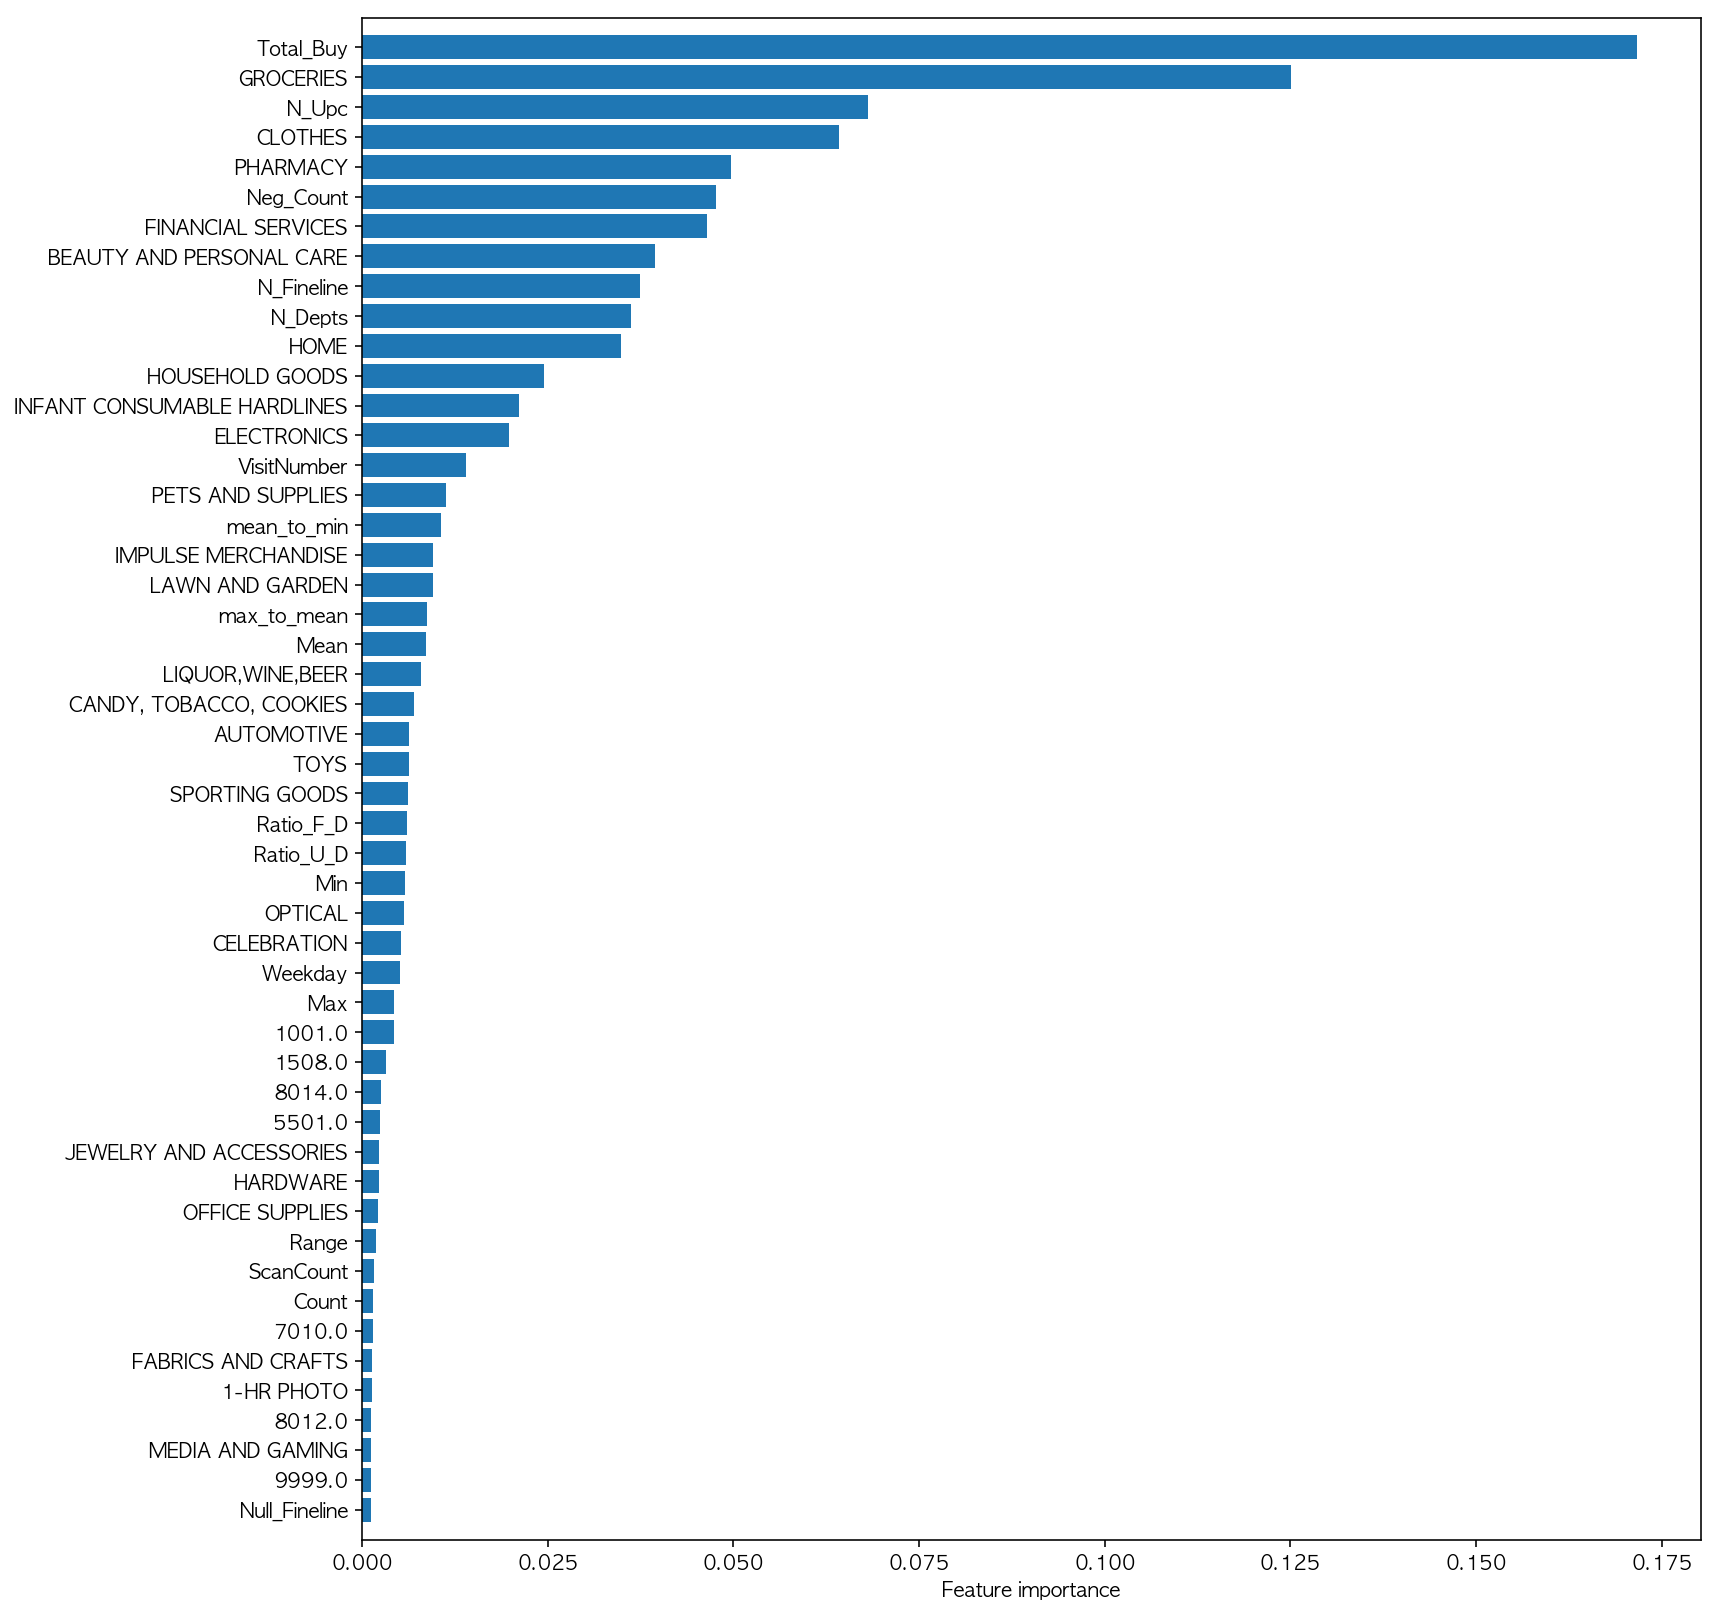

In [61]:
importance = rf.feature_importances_
pairs = []
for idx, value in enumerate(importance):
    pairs.append((abs(value), X.columns[idx]))
pairs.sort(key=lambda x: x[0], reverse=True)
# for pair in pairs[:20]:
#     print("importance: {:4f} feature: {}".format(pair[0], pair[1]))
importance.sort()
importance = importance[::-1]

labels = [label[1] for label in pairs]

plt.figure(figsize=(12, 14))
plt.barh(range(50), importance[:50][::-1], align="center")
plt.yticks(np.arange(50), labels[:50][::-1])
plt.xlabel("Feature importance")
plt.ylim(-1, 50)
plt.show()

In [8]:
def make_fineline_dummies_test(data):
    """
    OneHotEncoding FinelineNumber which appear 
    more than 500 times each Trip Type.
    """
#     train_fineline = original_data["FinelineNumber"].unique()
#     test_fineline = original_test["FinelineNumber"].unique()
#     intersection_fineline = list(set(train_fineline).intersection(set(test_fineline)))
    
    fineline_ranks = original_train.FinelineNumber.value_counts()
    fineline_ranks = fineline_ranks[fineline_ranks > 500]
#     columns1 = list(fineline_ranks.index)
    dummies = pd.get_dummies(data.FinelineNumber)
    dummies = dummies[fineline_ranks.index]
    
    data_visit = original_test[["VisitNumber"]]
    dummy_data = pd.concat([dummies, data_visit], axis=1)
    dummy_data = dummy_data.groupby("VisitNumber", as_index=False).aggregate(np.sum) # agg("sum")보다 더 나은 성능
    return dummy_data

In [9]:
wd = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3, 
    "Friday": 4,
    "Saturday": 5,
    "Sunday": 6,
}

test["Weekday"] = test["Weekday"].apply(lambda x: wd[x])

test["Count"] = test["ScanCount"]
test.loc[test.Count < 0, "Count"] = 0
test["FinelineNumber"].fillna(value=9999, inplace=True)

In [10]:
df = test.groupby(["VisitNumber", "DepartmentDescription"], as_index=False)["Count"].sum()

df1 = df.groupby(["VisitNumber"], as_index=False)["Count"].min()
df1.rename(columns={"Count": "Min"}, inplace=True)

df2 = df.groupby(["VisitNumber"], as_index=False)["Count"].max()
df2.rename(columns={'Count': "Max"}, inplace=True)

df3 = df.groupby(["VisitNumber"], as_index=False)["Count"].mean()
df3.rename(columns={"Count": "Mean"}, inplace=True)

test = test.merge(df1, how='left', on=["VisitNumber"], copy=True)
test = test.merge(df2, how='left', on=["VisitNumber"], copy=True)
test = test.merge(df3, how='left', on=["VisitNumber"], copy=True)  

In [11]:
test["Range"] = test["Max"] - test["Min"]

df = test[test["DepartmentDescription"].isnull()]
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "Null_Depts"}, inplace=True)
test = test.merge(df, how='left', on=["VisitNumber"], copy=True) 
test["Null_Depts"].fillna(value=0, inplace=True) 
test.loc[test.Null_Depts > 0, "Null_Depts"] = 1

In [12]:
df = test[test["ScanCount"] < 0]
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "Neg_Count"}, inplace=True) 
test = test.merge(df, how='left', on=["VisitNumber"], copy=True)
test["Neg_Count"].fillna(value=0, inplace=True)
test.loc[test.Neg_Count > 0, "Neg_Count"] = 1

In [13]:
df = test[test["FinelineNumber"]==9999]
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "Null_Fineline"}, inplace=True)
test = test.merge(df, how='left', on=["VisitNumber"], copy=True) 

In [14]:
test["Null_Fineline"].fillna(value=0, inplace=True)
test.loc[test.Null_Fineline > 0, "Null_Fineline"] = 1

In [15]:
df = test.groupby(["VisitNumber",  "FinelineNumber"], as_index=False)["Count"].count()
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "N_Fineline"}, inplace=True) 
test = test.merge(df, how='left', on=["VisitNumber"], copy=True)

In [16]:
df = test.groupby(["VisitNumber",  "Upc"], as_index=False)["Count"].count()
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "N_Upc"}, inplace=True) 
test = test.merge(df, how='left', on=["VisitNumber"], copy=True) 

In [19]:
# 커널이 죽음... ???
df_ = test.groupby(["VisitNumber", "DepartmentDescription"], as_index=False)["Count"].count()

In [20]:
df_ = df_.groupby(["VisitNumber"], as_index=False)["Count"].count()

In [21]:
df_.rename(columns={"Count": "N_Depts"}, inplace=True) 
test = test.merge(df_, how='left', on=["VisitNumber"], copy=True)

In [22]:
df = test.groupby(["VisitNumber"], as_index=False)["Count"].sum()
df.rename(columns={"Count": "Total_Buy"}, inplace=True)
test = test.merge(df, how='left', on=["VisitNumber"], copy=True)

In [23]:
test["Ratio_F_D"] = test["N_Fineline"] / test["N_Depts"]
test["Ratio_U_D"] = test["N_Upc"] / test["N_Depts"]

test["mean_to_min"] = test["Mean"] / test["Min"]
test.loc[test.mean_to_min==0, "mean_to_min"] = 1
test['max_to_mean'] = test["Max"] / test["Mean"]
test.loc[test.max_to_mean==0, "max_to_mean"] = 1

test.drop("Upc", axis=1, inplace=True)

In [24]:
depts_dummies = pd.get_dummies(test.DepartmentDescription)

depts_dummies_test = pd.concat([test[["VisitNumber"]], depts_dummies], axis=1)
depts_dummies_test_grouped = depts_dummies_test.groupby("VisitNumber", as_index=False).sum()
depts_dummies_test_grouped.shape

(95674, 68)

In [25]:
# fineline_dummies_test = pd.get_dummies(test.FinelineNumber)
# fineline_dummies_test = pd.concat([test[["VisitNumber"]], fineline_dummies_test], axis=1)

In [26]:
fineline_dummies_test_grouped = make_fineline_dummies_test(test)

In [27]:
test = test.replace(np.inf, 0)
test = test.fillna(value=0)
test.drop(["DepartmentDescription", "FinelineNumber"], axis=1, inplace=True)

In [28]:
test_by_max = test.groupby("VisitNumber", as_index=False).agg(np.max)
test_grouped = test_by_max.merge(depts_dummies_test_grouped, how='left', on=["VisitNumber"])
test_grouped = test_grouped.merge(fineline_dummies_test_grouped, how='left', on=["VisitNumber"])
test_grouped.shape

(95674, 359)

In [29]:
X_test = test_grouped

X_test["OPTICAL"] = X_test["OPTICAL - LENSES"] + X_test["OPTICAL - FRAMES"]
X_test["DELI"] = X_test["SERVICE DELI"] + X_test["PRE PACKED DELI"]

X_test["WOMENS CLOTHES"] = X_test["PLUS AND MATERNITY"] + X_test["LADIES SOCKS"] + X_test["LADIES SOCKS"] +\
X_test["BRAS & SHAPEWEAR"]

X_test["ELECTRONICS"] = X_test["ELECTRONICS"] + X_test["PLAYERS AND ELECTRONICS"]
X_test["LADIESWEAR"] = X_test["LADIESWEAR"] + X_test["WOMENS CLOTHES"]

X_test["PHARMACY"] = X_test["PHARMACY RX"] + X_test["PHARMACY OTC"]
X_test["LAWN AND GARDEN"] = X_test["LAWN AND GARDEN"] + X_test["HORTICULTURE AND ACCESS"]
X_test["LADIESWEAR"] = X_test["SHEER HOSIERY"] + X_test["LADIESWEAR"]

X_test["CLOTHES"] = X_test["BOYS WEAR"] + X_test["MENSWEAR"] + X_test["SWIMWEAR/OUTERWEAR"] + X_test['GIRLS WEAR, 4-6X  AND 7-14'] +\
X_test["INFANT APPAREL"] + X_test["LADIESWEAR"] + X_test["MENS WEAR"] + X_test["SLEEPWEAR/FOUNDATIONS"]    

X_test["GROCERIES"] = X_test["BAKERY"] + X_test["COMM BREAD"] + X_test["DAIRY"] + X_test["DSD GROCERY"] + X_test["FROZEN FOODS"] +\
X_test["GROCERY DRY GOODS"] + X_test["MEAT - FRESH & FROZEN"] + X_test["PRODUCE"] + X_test["SEAFOOD"] + X_test["DELI"]

X_test["CLOTHES"] = X_test["CLOTHES"] + X_test["SHOES"]
X_test["HOME"] = X_test["BATH AND SHOWER"] + X_test["HOME DECOR"] + X_test["HOME MANAGEMENT"] + X_test["BEDDING"] +\
X_test["COOK AND DINE"] + X_test["FURNITURE"] + X_test["LARGE HOUSEHOLD GOODS"] + X_test["SEASONAL"]      

X_test["JEWELRY AND ACCESSORIES"] = X_test["JEWELRY AND SUNGLASSES"] + X_test["ACCESSORIES"]    
X_test["ELECTRONICS"] = X_test["ELECTRONICS"] + X_test["CAMERAS AND SUPPLIES"]

X_test['HOUSEHOLD GOODS'] = X_test['HOUSEHOLD PAPER GOODS'] + X_test['HOUSEHOLD CHEMICALS/SUPP'] 
X_test["ELECTRONICS"] = X_test["ELECTRONICS"] + X_test["WIRELESS"]
X_test["BEAUTY AND PERSONAL CARE"] = X_test["BEAUTY"] + X_test["PERSONAL CARE"]

to_drop = ["OPTICAL - FRAMES", "OPTICAL - LENSES", "CONCEPT STORES", 
           "OTHER DEPARTMENTS", "PRE PACKED DELI", "SERVICE DELI", "PLUS AND MATERNITY", "LADIES SOCKS", 
           "BRAS & SHAPEWEAR", "PLAYERS AND ELECTRONICS", "WOMENS CLOTHES", "PHARMACY RX", "PHARMACY OTC", 
           "HORTICULTURE AND ACCESS", "SHEER HOSIERY", "BOYS WEAR", "MENSWEAR", "SWIMWEAR/OUTERWEAR", 
           "GIRLS WEAR, 4-6X  AND 7-14", "INFANT APPAREL", "LADIESWEAR", "MENS WEAR", "SLEEPWEAR/FOUNDATIONS", 
           "BAKERY", "COMM BREAD", "DAIRY", "DSD GROCERY", "FROZEN FOODS", "GROCERY DRY GOODS", 
           "MEAT - FRESH & FROZEN","PRODUCE", "SEAFOOD", "DELI", "SHOES", "HOME DECOR", "BATH AND SHOWER",
           "HOME MANAGEMENT", "BEDDING","COOK AND DINE", "FURNITURE", "LARGE HOUSEHOLD GOODS", 
           "SEASONAL", "JEWELRY AND SUNGLASSES", "ACCESSORIES", "CAMERAS AND SUPPLIES", 
           "HOUSEHOLD CHEMICALS/SUPP", "HOUSEHOLD PAPER GOODS", "WIRELESS", "BEAUTY", "PERSONAL CARE"]

In [30]:
X_test = X_test.drop(to_drop, axis=1)

In [32]:
import pickle
model = pickle.load(open("pw.pickle", "rb"))

In [35]:
# 커널 죽을 때
prob = model.predict_proba(X_test)

In [31]:
# pred_test = rf.predict(X_test)

NameError: name 'rf' is not defined

In [42]:
pred = model.predict(X_test)

In [37]:
sample = pd.read_csv("../dataset/sample_submission 2.csv")

In [86]:
featured = pd.read_csv("./train_featured.csv")

In [46]:
pred_dummies = pd.get_dummies(pred)
pred_dummies.columns = pred_dummies.columns.map(lambda x: str('TripType_') + str(x))

In [48]:
pred_dummies_concat = pd.concat([sample[["VisitNumber"]], pred_dummies], axis=1)

In [87]:
prob_df = pd.DataFrame(prob, columns=model.classes_)
prob_df.columns = prob_df.columns.map(lambda x: str('TripType_') + str(x))
sub = pd.concat([featured[["VisitNumber"]], prob_df], axis=1)

In [88]:
sub.to_csv("./submission_0408.csv", index=False)

In [ ]:
pro

In [124]:
prob = rf.predict_proba(X_test)

In [126]:
classes = rf.classes_

In [137]:
prob.shape

(38270, 38)

In [138]:
df_sub = pd.DataFrame(prob, columns=classes)
df_vn = X[["VisitNumber"]]

In [ ]:
submission = pd.concat([df_vn, df_sub], axis=1)

In [ ]:
df_sub = pd.DataFrame(prob, columns=classes)
df_vn = pd.DataFrame(y, columns=["VisitNumber"])
submission = pd.concat([df_vn, df_sub], axis=1)
submission.columns = submission.columns

VisitNumberDF = pd.DataFrame(testDF.iloc[0::,0:1].values, columns=['VisitNumber'])

ProbabilitiesDF = pd.DataFrame(prob, columns=classes)
ProbabilitiesDF.columns = ProbabilitiesDF.columns.map(lambda x: str('TripType_') + str(x))
SubmissionDF = VisitNumberDF.join(ProbabilitiesDF)

# Department_Count_Product

In [48]:
dd_dummies = pd.get_dummies(train.DepartmentDescription)
dd_dummies.shape

(647054, 69)

In [49]:
dd_dummies_2 = dd_dummies.copy()

In [50]:
for i in range(dd_dummies.shape[1]):
    dd_dummies_2['Ratio_%s' % (dd_dummies_2.columns[i])] = dd_dummies_2[i]/train['Sum']

#sum이 0이면 NaN이 발생한다
dd_dummies_2.fillna(value=0, inplace=True)

In [51]:
dd_dummies_ratio = dd_dummies_2.iloc[:, 69:]
dd_dummies_ratio.shape

(647054, 69)

### DepartmentDescription_Count

- DepartmentDescription을 모두 Dummy 변수로 추가하는 내용. (get_dummy로 대체 가능)
- VisitNumber별로 발생한 각 DepartmentDescription이, Visitnumber의 전체 ScanCount(판매량)에서 차지하는 비율 ( Ratio_$i$ ) 추가

* * * *

# Department_Count_Neg

In [52]:
dd_dummies_2 = dd_dummies.copy()

In [53]:
for i in range(69):
    dd_dummies_2['Return_%s' % (dd_dummies_2.columns[i])] = dd_dummies_2[i]*train['ScanCount'][train['ScanCount'] < 0]
    
dd_dummies_2.fillna(value=0, inplace=True)

In [54]:
dd_dummies_return_count = dd_dummies_2.iloc[:, 69:]
dd_dummies_return_count.shape

(647054, 69)

* * * *

# Department_Counts_Multiple_Products

In [55]:
dd_dummies_2 = dd_dummies.copy()

In [56]:
for i in range(69):
    dd_dummies_2['Multi_Count_%s' % (dd_dummies_2.columns[i])] = dd_dummies_2[i]*train['ScanCount'][train['ScanCount'] > 1 ]
    
dd_dummies_2.fillna(value=0, inplace=True)

In [57]:
dd_dummies_multi_count = dd_dummies_2.iloc[:, 69:]
dd_dummies_multi_count.shape

(647054, 69)

# Department_Counts_Multiple_Rows 
### (각 DD별로 VisitType 당  몇 번 등장하는지 더미변수 생성, 구매/반품 상관 X)

# Department_Counts_Rows_Pos_ScanCount

### (구매를 위한 Scan을 몇 번 했는지, 각 DD별로 더미변수 생성)

# Department_Counts_Rows_Neg_Scancount

### (반품을 위한 Scan을 몇 번 했는지, 각 DD별로 더미변수 생성)

* * * *

# Fineline_Count 

- Fineline 더미변수 추가

In [58]:
train.shape

(647054, 23)

In [59]:
fine_dummies  = pd.get_dummies(train.FinelineNumber)
fine_dummies.shape

(647054, 5196)

### Fineline Count 요약
- Fineline을 모두 Dummy 변수로 추가하는 내용. (get_dummy로 대체 가능)

In [60]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Count,Min,Max,...,Has_Neg,Missing,N_Fineline,N_Upc,N_Dep,Sum,Ratio_F_D,Ratio_U_D,mean_to_min,max_to_mean
0,999,5,0,6.811315e+10,-1,20,1000.0,0,0,0,...,1.0,0.0,1,1,1,0,1.000000,1.0,0.000000,0.000000
1,30,7,0,6.053882e+10,1,62,8931.0,1,1,1,...,0.0,0.0,2,2,2,2,1.000000,1.0,1.000000,1.000000
2,30,7,0,7.410811e+09,1,50,4504.0,1,1,1,...,0.0,0.0,2,2,2,2,1.000000,1.0,1.000000,1.000000
3,26,8,0,2.238404e+09,2,49,3565.0,2,1,20,...,1.0,1.0,17,21,7,30,2.428571,3.0,4.285714,4.666667
4,26,8,0,2.006614e+09,2,49,1017.0,2,1,20,...,1.0,1.0,17,21,7,30,2.428571,3.0,4.285714,4.666667


In [61]:
train = pd.concat([train, dd_dummies_ratio], axis=1)
train = pd.concat([train, dd_dummies_return_count], axis=1)
train = pd.concat([train, dd_dummies_multi_count], axis=1)
train = pd.concat([train, fine_dummies], axis=1)

print(train.shape)
train.head()

(647054, 5426)


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Count,Min,Max,...,9966.0,9967.0,9970.0,9971.0,9974.0,9975.0,9991.0,9997.0,9998.0,9999.0
0,999,5,0,6.811315e+10,-1,20,1000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30,7,0,6.053882e+10,1,62,8931.0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,30,7,0,7.410811e+09,1,50,4504.0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,26,8,0,2.238404e+09,2,49,3565.0,2,1,20,...,0,0,0,0,0,0,0,0,0,0
4,26,8,0,2.006614e+09,2,49,1017.0,2,1,20,...,0,0,0,0,0,0,0,0,0,0


In [64]:
train_2 = train.copy()

# Department_Dummies (Merge 하는 과정 추정... 아직 모르겠음)

# 다음과 같이 추리고 나서 시도 해볼 수 있음

- Product counts for 70% most frequent Fineline products
- Department dummies and their two-way interactions (only for 60% most frequent departments)

# Train Data에 적용

- "HEALTH AND BEAUTY AIDS" 드랍